In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import talib as ta
from talib import abstract
import yfinance as yfin
from arch import arch_model
import os
from datetime import timedelta


pd.set_option('display.float_format', '{:.2f}'.format)


## 資料DataFrame

In [30]:
df = yfin.download('^TWII', start = '2018-1-1', end = '2024-8-10')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

[*********************100%%**********************]  1 of 1 completed


# function

In [31]:
def get_llt(df, a):
    llt = np.zeros(len(df))
    llt[0] = df['close'].iloc[0]
    llt[1] = (1 - a) * df['close'].iloc[0] + a * df['close'].iloc[1]
    for n in range(2, len(df)):
        llt[n] = ((a - (a ** 2)/4) * df['close'].iloc[n]) + (((a ** 2)/2) * df['close'].iloc[n - 1]) - ((a - (3 * (a ** 2))/4) * df['close'].iloc[n - 2]) + ((2 * (1 - a)) * llt[n - 1]) - (((1 - a) ** 2) * llt[n - 2])
    
    df['llt'] = llt
    df['llt_slope'] = np.nan

    for i in range(0, len(df)):
        df.loc[df.index[i], 'llt_slope'] = df['llt'].iloc[i] - df['llt'].iloc[i - 1]
    return df


def bolinger_band(df, p, q, rolling, num_vol, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold):
    model = arch_model(df['llt'].dropna(), vol = 'Garch', p = p, q = q, rescale = False)
    garch_fit = model.fit(disp = 'off')
    df['garch_volitility'] = garch_fit.conditional_volatility

    df['bolinger_upper'] = df['llt'] + num_vol * df['garch_volitility']
    df['bolinger_lower'] = df['llt'] - num_vol * df['garch_volitility']

    df['bolinger_upper_smooth'] = df['bolinger_upper'].ewm(span = rolling).mean()
    df['bolinger_lower_smooth'] = df['bolinger_lower'].ewm(span = rolling).mean()

    df = get_middle(df)

    df['upper_max'] = df['bolinger_upper'].rolling(window = rolling).max()
    df['lower_min'] = df['bolinger_lower'].rolling(window = rolling).min()

    df['upper_retrace'] = (df['upper_max'] - df['bolinger_upper']) / df['upper_max']
    df['lower_retrace'] = (df['bolinger_lower'] - df['lower_min']) / df['lower_min']

    df['upper_deviation'] = (df['bolinger_upper'] - df['llt']) / df['llt']
    df['lower_deviation'] = (df['llt'] - df['bolinger_lower']) / df['llt']

    df['upper_rise'] = df['upper_deviation'] >= upper_threshold
    df['lower_down'] = df['lower_deviation'] >= lower_threshold
    df['upper_down'] = df['upper_retrace'] >= retrace_u_threshold
    df['lower_rise'] = df['lower_retrace'] >= retrace_l_threshold

    return df

def get_middle(df):
    
    df['middle'] = np.nan
    df.loc[df.index[0], 'middle'] = df['close'].iloc[0]

    for i in range(1, len(df)):

        upper_change = abs(df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1])
        lower_change = abs(df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1])
        
        peak_upward = upper_change > lower_change
        peak_downward = upper_change < lower_change
    
        if peak_upward:
            df.iloc[i, df.columns.get_loc('middle')] = ((df['middle'].iloc[i - 1] * i) + df['bolinger_lower_smooth'].iloc[i]) / (i + 1)
        elif peak_downward:
            df.iloc[i, df.columns.get_loc('middle')] = ((df['middle'].iloc[i - 1] * i) + df['bolinger_upper_smooth'].iloc[i]) / (i + 1)
    
    return df



# strategy

## LLT

In [32]:
def llt_strategy(df, feePaid, a, p, q, num_vol, rolling, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold, deviation_threshold, distance_threshold, drawdown):
    
    ret_df = pd.DataFrame(index = df.index)
    equity = pd.DataFrame(index = df.index)
    
    df = get_llt(df, a)
    df = bolinger_band(
        df = df, p = p, q = q, rolling = rolling, num_vol = num_vol,
        upper_threshold = upper_threshold, lower_threshold = lower_threshold,
        retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold)
    df = get_middle(df)

    BS = None
    t = 0
    df['Bull'] = False
    df['Bear'] = False
    df['Consolidation'] = False
    ret_df = ret_df.assign(
        position = np.zeros(len(df)),
        buy = np.zeros(len(df)),
        sell = np.zeros(len(df)),
        sellshort = np.zeros(len(df)),
        buytocover = np.zeros(len(df)),
        buy_price = np.zeros(len(df)),
        sell_price = np.zeros(len(df)),
        short_price = np.zeros(len(df)),
        buytocover_price = np.zeros(len(df)),
        buy_time = np.nan,
        sell_time = np.nan,
        sellshort_time = np.nan,
        buytocover_time = np.nan,
        hold_duration = np.nan,
        profit_list = np.zeros(len(df)),
        profit_fee_list = np.zeros(len(df)),
        profit_fee_list_realized = np.zeros(len(df))
    )
    ret_df['buy_time'] = pd.to_datetime(ret_df['buy_time'], errors='coerce')
    ret_df['sell_time'] = pd.to_datetime(ret_df['sell_time'], errors='coerce')
    ret_df['sellshort_time'] = pd.to_datetime(ret_df['sellshort_time'], errors='coerce')
    ret_df['buytocover_time'] = pd.to_datetime(ret_df['buytocover_time'], errors='coerce')

    for i in range(2, len(df) - 1):
        
        condition1 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) > (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向上
        condition2 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) < (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向下
        condition3 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) > 0 # 上軌向上
        condition4 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) < 0 # 上軌向下
        condition5 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) > 0 # 下軌向上
        condition6 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) < 0 # 下軌向下

        entryLong = (df['llt_slope'].iloc[i] > 0) & (((df['upper_rise'].iloc[i] == True) & condition1) | ((df['lower_rise'].iloc[i] == True) & condition2))
        exitLong = ((df['bolinger_upper'].iloc[i] < df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition4) | ((df['bolinger_lower'].iloc[i] < df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition6)
        entryShort = (df['llt_slope'].iloc[i] < 0) & (((df['upper_down'].iloc[i] == True) & condition1) | ((df['lower_down'].iloc[i] == True) & condition2))
        exitShort = ((df['bolinger_upper'].iloc[i] > df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition3) | ((df['bolinger_lower'].iloc[i] > df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition5)

        df.at[df.index[i], 'Consolidation'] = (df['upper_deviation'].iloc[i] < deviation_threshold) & (df['lower_deviation'].iloc[i] < deviation_threshold)
        if df['Consolidation'].iloc[i] == False:
            df.at[df.index[i], 'Bull'] = (condition1 & condition3) | (condition2 & condition5)
            df.at[df.index[i], 'Bear'] = (condition1 & condition4) | (condition2 & condition6)

        if BS == None:
            if df['Consolidation'].iloc[i]:
                print('這裡不會交易，所以可以放心用consolidation測這段')
            else:
                if df['Bull'].iloc[i]:
                    if entryLong:
                        BS = 'B'
                        t = i + 1
                        ret_df.at[ret_df.index[t], 'buy'] = t
                        ret_df.at[ret_df.index[t], 'buy_price'] = df['open'].iloc[t]
                        ret_df.at[ret_df.index[t], 'buy_time'] = df.index[t]
                        ret_df.at[ret_df.index[t], 'position'] += 1

                elif df['Bear'].iloc[i]:
                    if entryShort:
                        BS = 'S'
                        t = i + 1
                        ret_df.at[ret_df.index[t], 'sellshort'] = t
                        ret_df.at[ret_df.index[t], 'short_price'] = df['open'].iloc[t]
                        ret_df.at[ret_df.index[t], 'sellshort_time'] = df.index[t]
                        ret_df.at[ret_df.index[t], 'position'] -= 1

        elif BS == 'B':
            
            ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
            ret_df.at[ret_df.index[i], 'profit_list'] = profit

            if exitLong:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'position'] -= 1
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                BS = None

                ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

            elif i == len(df) - 2:
                if ret_df['position'].iloc[len(df) - 2] != 0:
                    unit = ret_df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    ret_df.at[ret_df.index[i + 1], 'position'] -= unit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                    BS = None

            else:
                profit_fee = profit
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        elif BS == 'S':
            ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
            ret_df.at[ret_df.index[i], 'profit_list'] = profit

            if exitShort:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'position'] += 1
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                ret_df.at[ret_df.index[i + 1], 'buytocover_price'] = df['open'].iloc[i + 1]
                ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                BS = None

                profit_fee_realized = pl_round - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = profit_fee_realized

            elif i == len(df) - 2:
                if ret_df['position'].iloc[len(df) - 2] != 0:
                    unit = ret_df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    ret_df.at[ret_df.index[i + 1], 'position'] += unit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                    BS = None
            else:
                profit_fee = profit
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        else:
            print('error')
                
    df['strategy_ret'] = ret_df['profit_list'].cumsum()
    equity['profitfee'] = ret_df['profit_fee_list'].cumsum()

    return df, ret_df, equity

## Consolidation

In [33]:

def consolidation_strategy(df, feePaid, a, p, q, num_vol, rolling, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold, deviation_threshold, distance_threshold, drawdown):
    ret_df = pd.DataFrame(index = df.index)
    equity = pd.DataFrame(index = df.index)
    
    df = get_llt(df, a)
    df = bolinger_band(
        df = df, p = p, q = q, rolling = rolling, num_vol = num_vol,
        upper_threshold = upper_threshold, lower_threshold = lower_threshold,
        retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold)
    df = get_middle(df)

    BS = None
    t = 0
    highest, trailing_stop = 0, 0
    df['Bull'] = False
    df['Bear'] = False
    df['Consolidation'] = False
    ret_df = ret_df.assign(
        position = np.zeros(len(df)),
        buy = np.zeros(len(df)),
        sell = np.zeros(len(df)),
        sellshort = np.zeros(len(df)),
        buytocover = np.zeros(len(df)),
        buy_price = np.zeros(len(df)),
        sell_price = np.zeros(len(df)),
        short_price = np.zeros(len(df)),
        buytocover_price = np.zeros(len(df)),
        buy_time = np.nan,
        sell_time = np.nan,
        sellshort_time = np.nan,
        buytocover_time = np.nan,
        hold_duration = np.nan,
        profit_list = np.zeros(len(df)),
        profit_fee_list = np.zeros(len(df)),
        profit_fee_list_realized = np.zeros(len(df))
    )
    ret_df['buy_time'] = pd.to_datetime(ret_df['buy_time'], errors='coerce')
    ret_df['sell_time'] = pd.to_datetime(ret_df['sell_time'], errors='coerce')
    ret_df['sellshort_time'] = pd.to_datetime(ret_df['sellshort_time'], errors='coerce')
    ret_df['buytocover_time'] = pd.to_datetime(ret_df['buytocover_time'], errors='coerce')

    for i in range(2, len(df) - 1):
        condition1 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) > (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向上
        condition2 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) < (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向下
        condition3 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) > 0 # 上軌向上
        condition4 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) < 0 # 上軌向下
        condition5 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) > 0 # 下軌向上
        condition6 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) < 0 # 下軌向下
        distance_llt_upper = abs(df['llt'].iloc[i] - df['bolinger_upper_smooth'].iloc[i])
        distance_llt_lower = abs(df['llt'].iloc[i] - df['bolinger_lower_smooth'].iloc[i])

        entryLong_c = distance_llt_lower <= (distance_threshold and distance_llt_upper)
        entryShort_c = distance_llt_upper <= (distance_threshold and distance_llt_lower)
        exitLong_c = df['close'].iloc[i] <= trailing_stop
        exitShort_c = df['close'].iloc[i] >= trailing_stop
        
        df.at[df.index[i], 'Consolidation'] = (df['upper_deviation'].iloc[i] < deviation_threshold) & (df['lower_deviation'].iloc[i] < deviation_threshold)
        
        if df['Consolidation'].iloc[i] == False:
            df.at[df.index[i], 'Bull'] = (condition1 & condition3) | (condition2 & condition5)
            df.at[df.index[i], 'Bear'] = (condition1 & condition4) | (condition2 & condition6)

        if BS == None:
            if df['Consolidation'].iloc[i]:
                if entryLong_c:
                    BS = 'B'
                    highest = df['open'].iloc[t]
                    trailing_stop = highest * (1 - drawdown)
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'buy'] = t
                    ret_df.at[ret_df.index[t], 'buy_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'buy_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] += 1

                elif entryShort_c:
                    BS = 'S'
                    highest = df['open'].iloc[t]
                    trailing_stop = highest * (1 + drawdown)
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'sellshort'] = t
                    ret_df.at[ret_df.index[t], 'short_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'sellshort_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] -= 1
                    
        elif BS == 'B':
            
            ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
            ret_df.at[ret_df.index[i], 'profit_list'] = profit

            if df['close'].iloc[i] > highest:
                highest = df['open'].iloc[i]
                trailing_stop = highest * (1 - drawdown)

            if exitLong_c:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'position'] -= 1
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                BS = None
                highest, trailing_stop = 0, 0
                ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

            elif i == len(df) - 2:
                if ret_df['position'].iloc[len(df) - 2] != 0:
                    unit = ret_df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    ret_df.at[ret_df.index[i + 1], 'position'] -= unit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                    BS = None

            else:
                profit_fee = profit
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        elif BS == 'S':

            ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
            ret_df.at[ret_df.index[i], 'profit_list'] = profit

            if df['close'].iloc[i] < highest:
                highest = df['open'].iloc[i]
                trailing_stop = highest * (1 + drawdown)

            if exitShort_c:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'position'] += 1
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                ret_df.at[ret_df.index[i + 1], 'buytocover_price'] = df['open'].iloc[i + 1]
                ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                BS = None
                highest, trailing_stop = 0, 0
                ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

            elif i == len(df) - 2:
                if ret_df['position'].iloc[len(df) - 2] != 0:
                    unit = ret_df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    ret_df.at[ret_df.index[i + 1], 'position'] += unit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                    BS = None

            else:
                profit_fee = profit
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        else:
            print('error')
                
    df['strategy_ret'] = ret_df['profit_list'].cumsum()
    equity['profitfee'] = ret_df['profit_fee_list'].cumsum()

    return df, ret_df, equity


In [34]:
## full

In [35]:
def full_strategy(df, feePaid, a, p, q, num_vol, rolling, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold, deviation_threshold, distance_threshold, drawdown):
    ret_df = pd.DataFrame(index = df.index)
    equity = pd.DataFrame(index = df.index)
    
    df = get_llt(df, a)
    df = bolinger_band(
        df = df, p = p, q = q, rolling = rolling, num_vol = num_vol,
        upper_threshold = upper_threshold, lower_threshold = lower_threshold,
        retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold)
    df = get_middle(df)

    BS = None
    t = 0
    highest, trailing_stop = 0, 0
    df['Bull'], ret_df['Bull'], equity['Bull'] = False, False, False
    df['Bear'], ret_df['Bear'], equity['Bear'] = False, False, False
    df['Consolidation'], ret_df['Consolidation'], equity['Consolidation'] = False, False, False
    ret_df = ret_df.assign(
        position = np.zeros(len(df)),
        buy = np.zeros(len(df)),
        sell = np.zeros(len(df)),
        sellshort = np.zeros(len(df)),
        buytocover = np.zeros(len(df)),
        buy_price = np.zeros(len(df)),
        sell_price = np.zeros(len(df)),
        short_price = np.zeros(len(df)),
        buytocover_price = np.zeros(len(df)),
        buy_time = np.nan,
        sell_time = np.nan,
        sellshort_time = np.nan,
        buytocover_time = np.nan,
        hold_duration = np.nan,
        profit_list = np.zeros(len(df)),
        profit_fee_list = np.zeros(len(df)),
        profit_fee_list_realized = np.zeros(len(df))
    )
    ret_df['buy_time'] = pd.to_datetime(ret_df['buy_time'], errors='coerce')
    ret_df['sell_time'] = pd.to_datetime(ret_df['sell_time'], errors='coerce')
    ret_df['sellshort_time'] = pd.to_datetime(ret_df['sellshort_time'], errors='coerce')
    ret_df['buytocover_time'] = pd.to_datetime(ret_df['buytocover_time'], errors='coerce')

    for i in range(2, len(df) - 1):
        
        condition1 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) > (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向上
        condition2 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) < (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向下
        condition3 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) > 0 # 上軌向上
        condition4 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) < 0 # 上軌向下
        condition5 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) > 0 # 下軌向上
        condition6 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) < 0 # 下軌向下
        distance_llt_upper = abs(df['llt'].iloc[i] - df['bolinger_upper_smooth'].iloc[i])
        distance_llt_lower = abs(df['llt'].iloc[i] - df['bolinger_lower_smooth'].iloc[i])
        
        entryLong = (df['llt_slope'].iloc[i] > 0) & (((df['upper_rise'].iloc[i] == True) & condition1) | ((df['lower_rise'].iloc[i] == True) & condition2))
        exitLong = ((df['bolinger_upper'].iloc[i] < df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition4) | ((df['bolinger_lower'].iloc[i] < df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition6)
        entryShort = (df['llt_slope'].iloc[i] < 0) & (((df['upper_down'].iloc[i] == True) & condition1) | ((df['lower_down'].iloc[i] == True) & condition2))
        exitShort = ((df['bolinger_upper'].iloc[i] > df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition3) | ((df['bolinger_lower'].iloc[i] > df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition5)
        entryLong_c = distance_llt_lower <= distance_threshold and distance_llt_lower <= distance_llt_upper
        entryShort_c = distance_llt_upper <= distance_threshold and distance_llt_upper <= distance_llt_lower

        exitLong_c = df['close'].iloc[i] <= trailing_stop
        exitShort_c = df['close'].iloc[i] >= trailing_stop

        df.at[df.index[i], 'Consolidation'] = (df['upper_deviation'].iloc[i] < deviation_threshold) & (df['lower_deviation'].iloc[i] < deviation_threshold)
        ret_df.loc[df['Consolidation'] == True, 'Consolidation'] = True
        equity.loc[df['Consolidation'] == True, 'Consolidation'] = True
        
        if df['Consolidation'].iloc[i] == False:
            df.at[df.index[i], 'Bull'] = (condition1 & condition3) | (condition2 & condition5)
            df.at[df.index[i], 'Bear'] = (condition1 & condition4) | (condition2 & condition6)
            

        ret_df.loc[df['Bull'] == True, 'Bull'] = True
        equity.loc[df['Bull'] == True, 'Bull'] = True
        ret_df.loc[df['Bear'] == True, 'Bear'] = True
        equity.loc[df['Bear'] == True, 'Bear'] = True

        if BS == None:
            if df['Consolidation'].iloc[i]:
                if entryLong_c:
                    BS = 'B'
                    highest = df['open'].iloc[t]
                    trailing_stop = highest * (1 - drawdown)
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'buy'] = t
                    ret_df.at[ret_df.index[t], 'buy_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'buy_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] += 1

                elif entryShort_c:
                    BS = 'S'
                    highest = df['open'].iloc[t]
                    trailing_stop = highest * (1 + drawdown)
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'sellshort'] = t
                    ret_df.at[ret_df.index[t], 'short_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'sellshort_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] -= 1
            elif df['Bull'].iloc[i]:
                if entryLong:
                    BS = 'B'
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'buy'] = t
                    ret_df.at[ret_df.index[t], 'buy_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'buy_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] += 1

            elif df['Bear'].iloc[i]:
                if entryShort:
                    BS = 'S'
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'sellshort'] = t
                    ret_df.at[ret_df.index[t], 'short_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'sellshort_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] -= 1

        elif BS == 'B':
            if df['Consolidation'].iloc[i]:
                ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
                profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
                ret_df.at[ret_df.index[i], 'profit_list'] = profit

                if df['close'].iloc[i] > highest:
                    highest = df['open'].iloc[i]
                    trailing_stop = highest * (1 - drawdown)

                if exitLong_c:
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    profit_fee = profit - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'position'] -= 1
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                    BS = None
                    highest, trailing_stop = 0, 0
                    ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

                elif i == len(df) - 2:
                    if ret_df['position'].iloc[len(df) - 2] != 0:
                        unit = ret_df['position'].iloc[len(df) - 2]
                        profit_fee = profit - feePaid * 2
                        pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                        ret_df.at[ret_df.index[i + 1], 'position'] -= unit
                        ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                        ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                        ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                        BS = None

                else:
                    profit_fee = profit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
            else:
                ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
                profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
                ret_df.at[ret_df.index[i], 'profit_list'] = profit

                if exitLong:
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    profit_fee = profit - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'position'] -= 1
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                    BS = None

                    ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

                elif i == len(df) - 2:
                    if ret_df['position'].iloc[len(df) - 2] != 0:
                        unit = ret_df['position'].iloc[len(df) - 2]
                        profit_fee = profit - feePaid * 2
                        pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                        ret_df.at[ret_df.index[i + 1], 'position'] -= unit
                        ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                        ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                        ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                        BS = None

                else:
                    profit_fee = profit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        elif BS == 'S':
            if df['Consolidation'].iloc[i]:
                ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
                profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
                ret_df.at[ret_df.index[i], 'profit_list'] = profit

                if df['close'].iloc[i] < highest:
                    highest = df['open'].iloc[i]
                    trailing_stop = highest * (1 + drawdown)

                if exitShort_c:
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    profit_fee = profit - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'position'] += 1
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'buytocover_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                    BS = None
                    highest, trailing_stop = 0, 0
                    ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

                elif i == len(df) - 2:
                    if ret_df['position'].iloc[len(df) - 2] != 0:
                        unit = ret_df['position'].iloc[len(df) - 2]
                        profit_fee = profit - feePaid * 2
                        pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                        ret_df.at[ret_df.index[i + 1], 'position'] += unit
                        ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                        ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                        ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                        BS = None

                else:
                    profit_fee = profit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
            else:            
                ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
                profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
                ret_df.at[ret_df.index[i], 'profit_list'] = profit

                if exitShort:
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    profit_fee = profit - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'position'] += 1
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'buytocover_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                    BS = None

                    profit_fee_realized = pl_round - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = profit_fee_realized

                elif i == len(df) - 2:
                    if ret_df['position'].iloc[len(df) - 2] != 0:
                        unit = ret_df['position'].iloc[len(df) - 2]
                        profit_fee = profit - feePaid * 2
                        pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                        ret_df.at[ret_df.index[i + 1], 'position'] += unit
                        ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                        ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                        ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                        BS = None
                else:
                    profit_fee = profit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        else:
            print('error')
                
    df['strategy_ret'] = ret_df['profit_list'].cumsum()
    equity['profitfee'] = ret_df['profit_fee_list'].cumsum()

    return df, ret_df, equity

# calculate metrics

In [36]:
def calculate_metrics(ret_df, equity, fund, risk_free_rate = 0.04 / 252):
    duration = (equity.index[-1] - equity.index[0]).days
    risk_free_rate = 0.04/252
    equity['equity'] = equity['profitfee'] + fund
    equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
    equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
    profit = equity['profitfee'].iloc[-1]
    ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
    mdd = abs(equity['drawdown_percent'].min())
    calmarRatio = ret / mdd
    tradeTimes = min((ret_df['buy'] > 0).sum(), (ret_df['sell'] > 0).sum()) + min((ret_df['sellshort'] > 0).sum(), (ret_df['buytocover'] > 0).sum())
    average_holding_duration = ret_df['hold_duration'].sum() / tradeTimes
    winRate = len([i for i in ret_df['profit_fee_list_realized'] if i > 0]) / tradeTimes
    try:
        profitFactor = sum([i for i in ret_df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in ret_df['profit_fee_list_realized'] if i < 0]))
    except:
        profitFactor = None
    mean_ret = ret_df['profit_list'].mean()
    std_ret = ret_df['profit_list'].std()
    sharp = (mean_ret - risk_free_rate) / std_ret

    metrics = {
        'duration' :  duration,
        'average_holding_duration': average_holding_duration,
        'profit': profit,
        'return': ret,
        'max_drawdown': mdd,
        'caimar_ratio': calmarRatio,
        'trade_times': tradeTimes,
        'win_rate': winRate,
        'profit_factor': profitFactor,
        'sharp_ratio': sharp
    }

    return metrics

# optimize

In [37]:
def optimize(strategy_fn, a_range, upper_threshold_range, lower_threshold_range, retrace_u_threshold_range, retrace_l_threshold_range, distance_threshold_range, drawdown_range, df, fund, feePaid, p = 1, q = 1, rolling = 20, num_vol = 1, deviation_threshold = 0.37):
    
    results = []

    for a in a_range:
        for upper_threshold in upper_threshold_range:
            for lower_threshold in lower_threshold_range:
                for retrace_u_threshold in retrace_u_threshold_range:
                    for retrace_l_threshold in retrace_l_threshold_range:
                        for distance_threshold in distance_threshold_range:
                            for drawdown in drawdown_range:
                                df_copy = df.copy()

                                df, ret_df, equity = strategy_fn(
                                    df_copy, feePaid, a = a, p = p, q = q, rolling = rolling, num_vol = num_vol,
                                    upper_threshold = upper_threshold, lower_threshold = lower_threshold,
                                    retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold,
                                    deviation_threshold = deviation_threshold, distance_threshold = distance_threshold, drawdown = drawdown
                                )

                                metrics = calculate_metrics(ret_df, equity, fund)

                                result = {
                                    'a': a,
                                    'p': p,
                                    'q': q,
                                    'num_vol': num_vol,
                                    'rolling': rolling,
                                    'upper_threshold': upper_threshold,
                                    'lower_threshold': lower_threshold,
                                    'retrace_u_threshold': retrace_u_threshold,
                                    'retrace_l_threshold': retrace_l_threshold,
                                    'distance_threshold': distance_threshold,
                                    'drawdown': drawdown,
                                    'duration' :  metrics['duration'],
                                    'average_holding_duration': metrics['average_holding_duration'],
                                    'profit': metrics['profit'],
                                    'return': metrics['return'],
                                    'max_drawDown': metrics['max_drawdown'],
                                    'caimar_ratio': metrics['caimar_ratio'],
                                    'trade_times': metrics['trade_times'],
                                    'win_rate': metrics['win_rate'],
                                    'profit_factor': metrics['profit_factor'],
                                    'sharp_ratio': metrics['sharp_ratio']
                                }
                                results.append(result)
                                print(f'a: {a}, upper_threshold: {upper_threshold},lower_threshold: {lower_threshold}, retrace_u_threshold: {retrace_u_threshold}, retrace_l_threshold: {retrace_l_threshold}, distance_threshold: {distance_threshold}, drawdown: {drawdown}')
    # print(results)
    results_df = pd.DataFrame(results)
    # print("Results DataFrame:")
    # print(results_df)
    # print("Columns:", results_df.columns)
    results_df.to_csv('results_df.csv')
    return results_df

# parametors

In [38]:
strategy_fn = llt_strategy
a = np.arange(0.5, 0.6, 0.1)
p = 1
q = 1
num_vol = 1
rolling = 20
upper_threshold = np.arange(0.04, 0.10, 0.02)
lower_threshold = np.arange(0.04, 0.10, 0.02)
retrace_u_threshold = np.arange(0.01, 0.08, 0.03)
retrace_l_threshold = np.arange(0.01, 0.08, 0.03)
deviation_threshold = 0.037
distance_threshold = np.arange(0.031, 0.04, 0.002)
drawdown = np.arange(0.026, 0.04, 0.003)
fund = 1000000
feePaid = 600
optimize_indicator = 'sharp_ratio'
insample_ranges = [
    ('2018-01-01', '2018-12-31'),
    ('2018-07-08', '2019-07-07'),
    ('2019-01-12', '2020-01-11'),
    ('2019-07-19', '2020-07-17'),
    ('2020-01-23', '2021-01-21'),
    ('2020-07-29', '2021-07-28'),
    ('2021-02-02', '2022-02-01'),
    ('2021-08-09', '2022-08-08'),
    ('2022-02-23', '2023-02-12'),
    ('2022-08-20', '2023-08-19')]
outsample_range = [
    ('2018-12-31', '2019-07-07'),
    ('2019-07-07', '2020-01-11'),
    ('2020-01-11', '2020-07-17'),
    ('2020-07-17', '2021-01-21'),
    ('2021-01-21', '2021-07-28'),
    ('2021-07-28', '2022-02-01'),
    ('2022-02-21', '2022-08-08'),
    ('2022-08-08', '2023-02-12'),
    ('2023-02-12', '2023-08-19'),
    ('2023-08-19', '2024-03-01')
    ]

# execute

In [39]:
'''
results_df = optimize(
    strategy_fn = strategy_fn, a_range = a,
    upper_threshold_range = upper_threshold, lower_threshold_range = lower_threshold,
    retrace_u_threshold_range = retrace_u_threshold, retrace_l_threshold_range = retrace_l_threshold,
    deviation_threshold = deviation_threshold, distance_threshold_range = distance_threshold, drawdown_range = drawdown,
    df = df, fund = fund, feePaid = feePaid, p = p, q = q, rolling = rolling, num_vol = num_vol)
'''

'\nresults_df = optimize(\n    strategy_fn = strategy_fn, a_range = a,\n    upper_threshold_range = upper_threshold, lower_threshold_range = lower_threshold,\n    retrace_u_threshold_range = retrace_u_threshold, retrace_l_threshold_range = retrace_l_threshold,\n    deviation_threshold = deviation_threshold, distance_threshold_range = distance_threshold, drawdown_range = drawdown,\n    df = df, fund = fund, feePaid = feePaid, p = p, q = q, rolling = rolling, num_vol = num_vol)\n'

# extract

In [40]:

def extract_best_params(results_df, optimize_indicator, ascending = False):
    sorted_df = results_df.sort_values(by = optimize_indicator, ascending = ascending)
    best_params = sorted_df.iloc[0].to_dict()
    return best_params
'''
best_params = extract_best_params(results_df = results_df, optimize_indicator = 'sharp_ratio')

results_df.to_csv('test.csv')
best_params
'''

"\nbest_params = extract_best_params(results_df = results_df, optimize_indicator = 'sharp_ratio')\n\nresults_df.to_csv('test.csv')\nbest_params\n"

# 純手工walk forward optimize

In [41]:

def optimize_by_date_range(df, optimize_fn, optimize_indicator, date_ranges, ascending = False):
    results = []
    for start_date, end_date in date_ranges:
        print(f'=================\n{start_date}, {end_date}\n====================')
        period_df = df[(df.index >= start_date) & (df.index <= end_date)]
        
        if period_df.empty:
            print(f"No data for period {start_date} to {end_date}")
            continue
        
        results_df = optimize_fn(
            full_strategy, a_range = a,
            upper_threshold_range = upper_threshold, lower_threshold_range = lower_threshold,
            retrace_u_threshold_range = retrace_u_threshold, retrace_l_threshold_range = retrace_l_threshold,
            deviation_threshold = deviation_threshold, distance_threshold_range = distance_threshold, drawdown_range = drawdown,
            df = period_df, fund = fund, feePaid = feePaid, p = p, q = q, rolling = rolling, num_vol = num_vol
        )
        
        best_params = extract_best_params(results_df, optimize_indicator, ascending)
        best_params['start_date'] = start_date
        best_params['end_date'] = end_date
        results.append(best_params)
    
    return pd.DataFrame(results)


In [42]:

params_df = optimize_by_date_range(
    df, optimize, 'sharp_ratio', date_ranges = insample_ranges)


params_df.to_csv('params_df.csv')


2018-01-01, 2018-12-31
a: 0.5, upper_threshold: 0.04,lower_threshold: 0.04, retrace_u_threshold: 0.01, retrace_l_threshold: 0.01, distance_threshold: 0.031, drawdown: 0.026
a: 0.5, upper_threshold: 0.04,lower_threshold: 0.04, retrace_u_threshold: 0.01, retrace_l_threshold: 0.01, distance_threshold: 0.031, drawdown: 0.028999999999999998
a: 0.5, upper_threshold: 0.04,lower_threshold: 0.04, retrace_u_threshold: 0.01, retrace_l_threshold: 0.01, distance_threshold: 0.031, drawdown: 0.032
a: 0.5, upper_threshold: 0.04,lower_threshold: 0.04, retrace_u_threshold: 0.01, retrace_l_threshold: 0.01, distance_threshold: 0.031, drawdown: 0.034999999999999996
a: 0.5, upper_threshold: 0.04,lower_threshold: 0.04, retrace_u_threshold: 0.01, retrace_l_threshold: 0.01, distance_threshold: 0.031, drawdown: 0.03799999999999999
a: 0.5, upper_threshold: 0.04,lower_threshold: 0.04, retrace_u_threshold: 0.01, retrace_l_threshold: 0.01, distance_threshold: 0.033, drawdown: 0.026
a: 0.5, upper_threshold: 0.04,low

# put best_params in

In [47]:
def run_strategy_on_dates(params_df, outsample_ranges, strategy_fn, df, fund, feePaid):
    all_ret_df = []
    all_equity = []

    for i, (start_date, end_date) in enumerate(outsample_ranges):
        
        param = params_df.iloc[i]
        date_range_df = df.loc[start_date : end_date]
        a = param['a']
        p = 1
        q = 1
        num_vol = 1
        rolling = 20
        upper_threshold = param['upper_threshold']
        lower_threshold = param['lower_threshold']
        retrace_u_threshold = param['retrace_u_threshold']
        retrace_l_threshold = param['retrace_l_threshold']
        deviation_threshold = 0.037
        distance_threshold = param['distance_threshold']
        drawdown = param['drawdown']
        fund = 1000000
        feePaid = 600

        date_range_df, full_ret_df, full_equity = full_strategy(
            df = date_range_df,
            feePaid = feePaid,
            a = a, p = p, q = q, num_vol = num_vol, rolling = rolling,
            upper_threshold = upper_threshold, lower_threshold = lower_threshold,
            retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold,
            deviation_threshold = deviation_threshold, distance_threshold = distance_threshold, drawdown = drawdown
        )
        
        all_ret_df.append(full_ret_df)
        all_equity.append(full_equity)

    combined_ret_df = pd.concat(all_ret_df)
    combined_equity = pd.concat(all_equity)

    return combined_ret_df, combined_equity

full_ret_df, full_equity = run_strategy_on_dates(params_df, outsample_range, full_strategy, df, fund=1000000, feePaid=600)
full_ret_df.to_csv('full_ret_df.csv')
full_equity.to_csv('full_equity.csv')


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_19513/4032093107.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['llt'] = llt
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_19513/4032093107.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['llt_slope'] = np.nan
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_19513/4032093107.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [59]:
bull_ret_df = full_ret_df[full_ret_df['Bull'] == True]
bear_ret_df = full_ret_df[full_ret_df['Bear'] == True]
consolidation_ret_df = full_ret_df[full_ret_df['Consolidation'] == True]
bull_equity = full_equity[full_equity['Bull'] == True]
bear_equity = full_equity[full_equity['Bear'] == True]
consolidation_equity = full_equity[full_equity['Consolidation'] == True]
no_c_ret_df = full_ret_df[full_ret_df['Consolidation'] == False]
no_c_equity = full_equity[full_equity['Consolidation'] == False]

In [60]:
def get_performance(ret_df, equity):
    duration = (equity.index[-1] - equity.index[0]).days
    risk_free_rate = 0.04/252
    equity['equity'] = equity['profitfee'] + fund
    equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
    equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
    profit = equity['profitfee'].iloc[-1]
    ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
    mdd = abs(equity['drawdown_percent'].min())
    calmarRatio = ret / mdd
    tradeTimes = min((ret_df['buy'] > 0).sum(), (ret_df['sell'] > 0).sum()) + min((ret_df['sellshort'] > 0).sum(), (ret_df['buytocover'] > 0).sum())
    average_holding_duration = ret_df['hold_duration'].sum() / tradeTimes
    winRate = len([i for i in ret_df['profit_fee_list_realized'] if i > 0]) / tradeTimes
    try:
        profitFactor = sum([i for i in ret_df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in ret_df['profit_fee_list_realized'] if i < 0]))
    except:
        profitFactor = None
    mean_ret = ret_df['profit_list'].mean()
    std_ret = ret_df['profit_list'].std()
    sharp = (mean_ret - risk_free_rate) / std_ret

    print('Duration : ', duration, 'days')
    print('Average holding duration', average_holding_duration, 'days')
    print('Profit : ', profit)
    print('Return : ', ret)
    print('Max DrawDown : ', mdd)
    print('Caimar Ratio : ', calmarRatio)
    print('Trade Times : ', tradeTimes)
    print('Win Rate : ', winRate)
    print('Profit Factor : ', profitFactor)
    print('Sharp Ratio : ', sharp)

print('------------------------------Total----------------------------------')
get_performance(full_ret_df, full_equity)
print('------------------------------Consolidation----------------------------------')
get_performance(consolidation_ret_df, consolidation_equity)
print('------------------------------Bull----------------------------------')
get_performance(bull_ret_df, bull_equity)
print('------------------------------Bear----------------------------------')
get_performance(bear_ret_df, bear_equity)
print('------------------------------Bull & Bear--------------------------')
get_performance(no_c_ret_df, no_c_equity)

------------------------------Total----------------------------------
Duration :  1885 days
Average holding duration 15.395348837209303 days
Profit :  -129514.0625
Return :  -0.12951406249999997
Max DrawDown :  0.5296442073088988
Caimar Ratio :  -0.24453031056084948
Trade Times :  43
Win Rate :  0.3488372093023256
Profit Factor :  0.8993446740869857
Sharp Ratio :  0.03267609755404692
------------------------------Consolidation----------------------------------
Duration :  1821 days
Average holding duration 137.0 days
Profit :  -220376.171875
Return :  -0.23407706711986198
Max DrawDown :  0.4173328543299142
Caimar Ratio :  -0.5608881847936588
Trade Times :  2
Win Rate :  4.0
Profit Factor :  4.042033843793138
Sharp Ratio :  0.0749103912349413
------------------------------Bull----------------------------------
Duration :  1877 days
Average holding duration 45.666666666666664 days
Profit :  -129514.0625
Return :  -0.07847832002190036
Max DrawDown :  0.5296442073088988
Caimar Ratio :  -0.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_19513/1591068375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equity['equity'] = equity['profitfee'] + fund
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_19513/1591068375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_19513/1591068375.py:6: SettingWithCopyWarning: 
A value is trying to be s

In [54]:
full_ret_df['index_ret'] = np.zeros(len(full_ret_df))

for i in range(1, len(df)):
    full_ret_df.loc[full_ret_df.index[i], 'index_ret'] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200

full_ret_df['cum_index_ret'] = full_ret_df['index_ret'].cumsum()

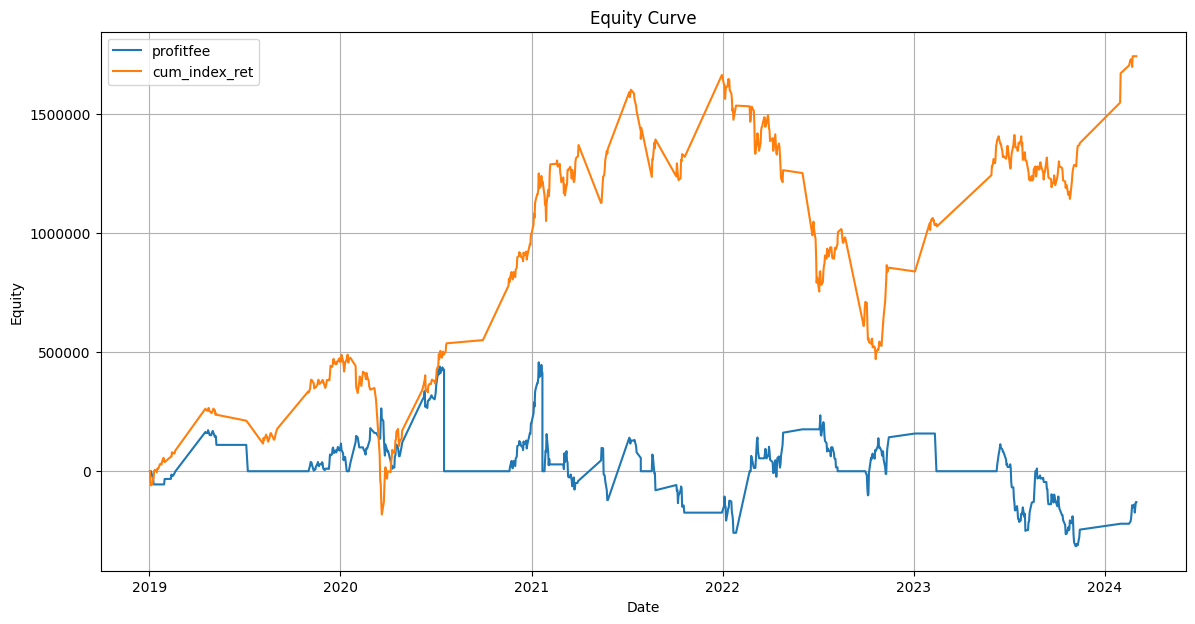

In [71]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(no_c_ret_df.index, no_c_equity['profitfee'], label='profitfee')
ax.plot(no_c_ret_df.index, no_c_ret_df['cum_index_ret'], label='cum_index_ret')

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.set_title('Equity Curve')
ax.legend()

plt.show()


In [65]:
a = 0.5
p = 1
q = 1
num_vol = 1
rolling = 20
upper_threshold = 0.04
lower_threshold = 0.04
retrace_u_threshold = 0.07
retrace_l_threshold = 0.07
deviation_threshold = 0.037
distance_threshold = 0.035
drawdown = 0.035
fund = 1000000
feePaid = 600

In [66]:
df = get_llt(df, a)
df = bolinger_band(
    df = df, p = p, q = q, rolling = rolling, num_vol = num_vol,
    upper_threshold = upper_threshold, lower_threshold = lower_threshold,
    retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold)
df = get_middle(df)

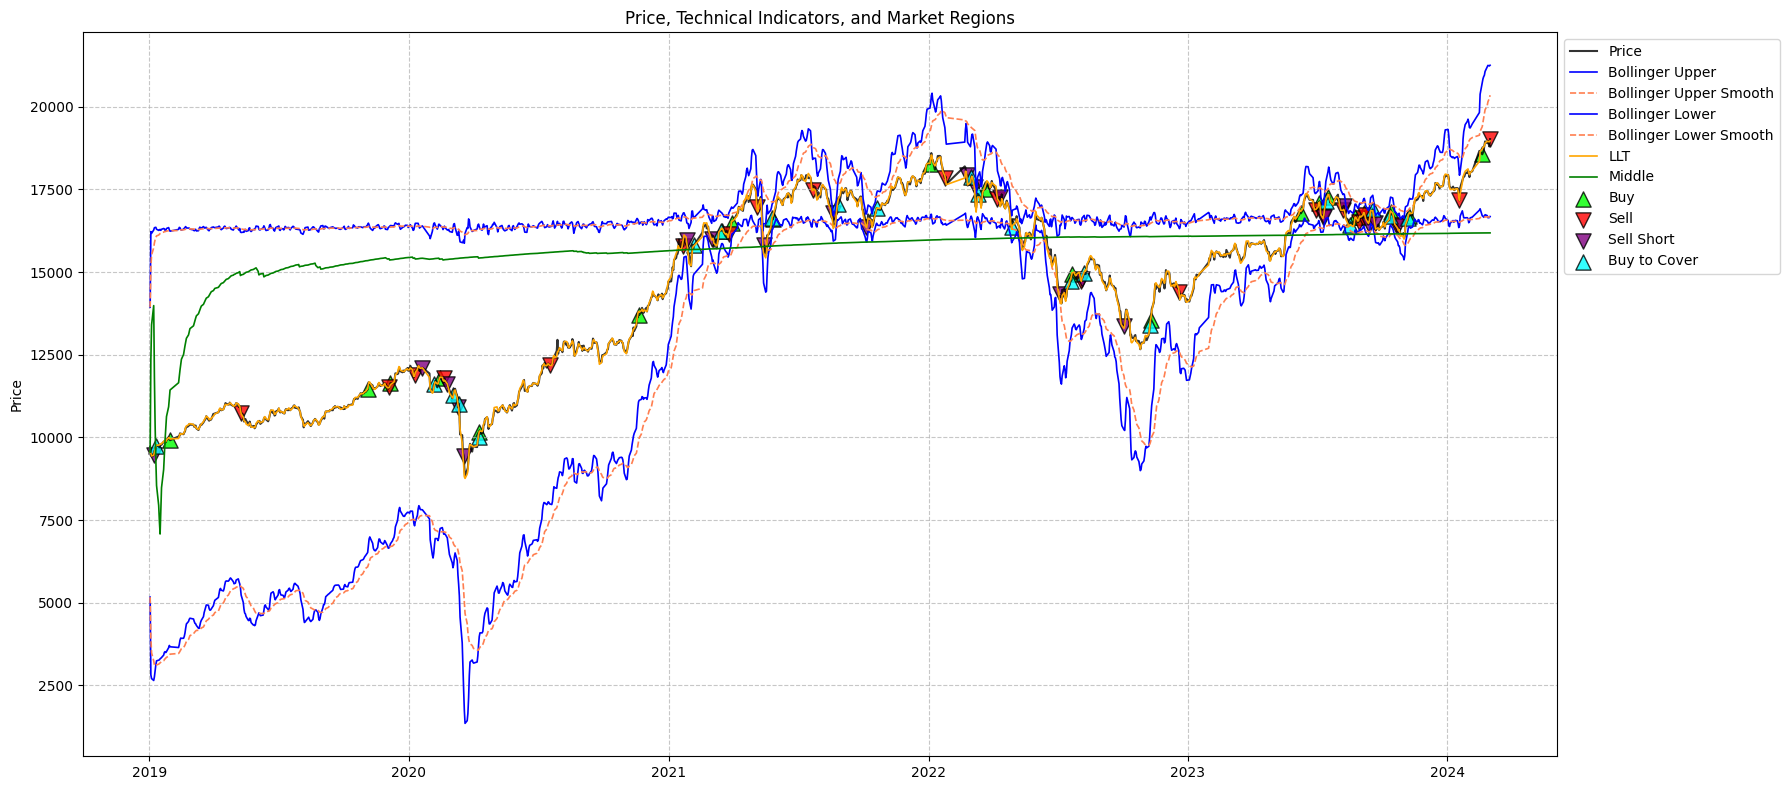

In [67]:
buy_points = full_ret_df[full_ret_df['buy'] > 0]
sell_points = full_ret_df[full_ret_df['sell'] > 0]
sellshort_points = full_ret_df[full_ret_df['sellshort'] > 0]
buytocover_points = full_ret_df[full_ret_df['buytocover'] > 0]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), sharex=True)

ax1.plot(df.index, df['open'], label='Price', color='black', alpha=0.8, linewidth=1.5)

ax1.plot(df.index, df['bolinger_upper'], label='Bollinger Upper', color='blue', linewidth=1.2)
ax1.plot(df.index, df['bolinger_upper_smooth'], label='Bollinger Upper Smooth', color='coral', linestyle='--', linewidth=1.2)

ax1.plot(df.index, df['bolinger_lower'], label='Bollinger Lower', color='blue', linewidth=1.2)
ax1.plot(df.index, df['bolinger_lower_smooth'], label='Bollinger Lower Smooth', color='coral', linestyle='--', linewidth=1.2)

ax1.plot(df.index, df['llt'], label='LLT', color='orange', linewidth=1.2)
ax1.plot(df.index, df['middle'], label='Middle', color='green', linewidth=1.2)

ax1.scatter(buy_points.index, df['open'].loc[buy_points.index], color='lime', edgecolor='black', marker='^', label='Buy', s=120, alpha=0.8)
ax1.scatter(sell_points.index, df['open'].loc[sell_points.index], color='red', edgecolor='black', marker='v', label='Sell', s=120, alpha=0.8)
ax1.scatter(sellshort_points.index, df['open'].loc[sellshort_points.index], color='purple', edgecolor='black', marker='v', label='Sell Short', s=120, alpha=0.8)
ax1.scatter(buytocover_points.index, df['open'].loc[buytocover_points.index], color='cyan', edgecolor='black', marker='^', label='Buy to Cover', s=120, alpha=0.8)

## 畫趨勢區域
# bull_region_label_shown = False
# bear_region_label_shown = False
# consolidation_region_label_shown = False
# for i in range(1, len(df)):
#     if df['Bull'].iloc[i]:
#         ax1.axvspan(df.index[i-1], df.index[i], color='lightgreen', alpha=0.5, label='Bull Region' if not bull_region_label_shown else "")
#         bull_region_label_shown = True
#     if df['Bear'].iloc[i]:
#         ax1.axvspan(df.index[i-1], df.index[i], color='lightcoral', alpha=0.5, label='Bear Region' if not bear_region_label_shown else "")
#         bear_region_label_shown = True
#     if df['Consolidation'].iloc[i]:
#         ax1.axvspan(df.index[i-1], df.index[i], color='gray', alpha=0.3, label='Consolidation Region' if not consolidation_region_label_shown else "")
#         consolidation_region_label_shown = True

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.set_title('Price, Technical Indicators, and Market Regions')
ax1.set_ylabel('Price')
ax1.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# 用不到

In [ ]:
'''
import pandas as pd
import numpy as np

# 假设你有一个参数的 DataFrame，params_df
# params_df 的列名应该包括时间段和参数
# 例如:
# params_df = pd.DataFrame({
#     'start_date': ['2024-01-01', '2024-02-01'],
#     'end_date': ['2024-01-31', '2024-02-28'],
#     'a': [0.1, 0.2],
#     'p': [10, 20],
#     'q': [0.5, 0.6],
#     # 其他参数
# })

results = []

for _, row in params_df.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']
    
    # 假设你有一个函数获取时间段数据
    df = get_data_for_date_range(start_date, end_date)
    
    # 提取参数
    feePaid = row['feePaid']
    a = row['a']
    p = row['p']
    q = row['q']
    num_vol = row['num_vol']
    rolling = row['rolling']
    upper_threshold = row['upper_threshold']
    lower_threshold = row['lower_threshold']
    retrace_u_threshold = row['retrace_u_threshold']
    retrace_l_threshold = row['retrace_l_threshold']
    deviation_threshold = row['deviation_threshold']
    distance_threshold = row['distance_threshold']
    drawdown = row['drawdown']
    
    # 运行策略
    ret_df, equity = full_strategy(
        df, feePaid, a, p, q, num_vol, rolling,
        upper_threshold, lower_threshold, retrace_u_threshold,
        retrace_l_threshold, deviation_threshold, distance_threshold, drawdown
    )
    
    # 将结果存储起来
    result = {
        'start_date': start_date,
        'end_date': end_date,
        'parameters': row.to_dict(),
        'results': ret_df,
        'equity': equity
    }
    
    results.append(result)

# 将所有结果合并成一个 DataFrame 或其他结构
results_df = pd.DataFrame(results)
'''

"\nimport pandas as pd\nimport numpy as np\n\n# 假设你有一个参数的 DataFrame，params_df\n# params_df 的列名应该包括时间段和参数\n# 例如:\n# params_df = pd.DataFrame({\n#     'start_date': ['2024-01-01', '2024-02-01'],\n#     'end_date': ['2024-01-31', '2024-02-28'],\n#     'a': [0.1, 0.2],\n#     'p': [10, 20],\n#     'q': [0.5, 0.6],\n#     # 其他参数\n# })\n\nresults = []\n\nfor _, row in params_df.iterrows():\n    start_date = row['start_date']\n    end_date = row['end_date']\n    \n    # 假设你有一个函数获取时间段数据\n    df = get_data_for_date_range(start_date, end_date)\n    \n    # 提取参数\n    feePaid = row['feePaid']\n    a = row['a']\n    p = row['p']\n    q = row['q']\n    num_vol = row['num_vol']\n    rolling = row['rolling']\n    upper_threshold = row['upper_threshold']\n    lower_threshold = row['lower_threshold']\n    retrace_u_threshold = row['retrace_u_threshold']\n    retrace_l_threshold = row['retrace_l_threshold']\n    deviation_threshold = row['deviation_threshold']\n    distance_threshold = row['distance_thre

In [ ]:
'''
results_df = pd.read_csv('walk_forward.csv')

def plot_parameter_heatmap(results_df, param1, param2, metric):
    pivot_table = results_df.pivot_table(index=param1, columns=param2, values=metric, aggfunc='mean')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
    plt.title(f'Heatmap of {metric} by {param1} and {param2}')
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.show()

def plot_parameter_scatter(results_df, param1, param2, metric):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=results_df, x=param1, y=metric, hue=param2, palette='viridis', alpha=0.7)
    plt.title(f'{param1} vs {metric} colored by {param2}')
    plt.xlabel(param1)
    plt.ylabel(metric)
    plt.legend(title=param2)
    plt.grid(True)
    plt.show()

plot_parameter_heatmap(results_df, 'distance_threshold', 'drawdown', 'profit_factor')
plot_parameter_scatter(results_df, 'distance_threshold', 'profit_factor', 'drawdown')
'''

'\nresults_df = pd.read_csv(\'walk_forward.csv\')\n\ndef plot_parameter_heatmap(results_df, param1, param2, metric):\n    pivot_table = results_df.pivot_table(index=param1, columns=param2, values=metric, aggfunc=\'mean\')\n    plt.figure(figsize=(12, 8))\n    sns.heatmap(pivot_table, cmap=\'viridis\', annot=True, fmt=".2f", linewidths=.5)\n    plt.title(f\'Heatmap of {metric} by {param1} and {param2}\')\n    plt.xlabel(param2)\n    plt.ylabel(param1)\n    plt.show()\n\ndef plot_parameter_scatter(results_df, param1, param2, metric):\n    plt.figure(figsize=(12, 6))\n    sns.scatterplot(data=results_df, x=param1, y=metric, hue=param2, palette=\'viridis\', alpha=0.7)\n    plt.title(f\'{param1} vs {metric} colored by {param2}\')\n    plt.xlabel(param1)\n    plt.ylabel(metric)\n    plt.legend(title=param2)\n    plt.grid(True)\n    plt.show()\n\nplot_parameter_heatmap(results_df, \'distance_threshold\', \'drawdown\', \'profit_factor\')\nplot_parameter_scatter(results_df, \'distance_threshold

# 以下是暫時寫不出來，但成果發表結束要完成的

In [ ]:
'''
def get_outsample(df, date_ranges, best_params):
    all_results = []
    for i, params in best_params.iterrows():
        results = []
        for start_date, end_date in date_ranges:
            print(f"Processing period {start_date} to {end_date} with params index {i}")
            period_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()

            if period_df.empty:
                print(f"No data for period {start_date} to {end_date}")
                continue

            period_df, ret_df, equity = llt_strategy(
                df=period_df, 
                feePaid=600,
                a=0.5, 
                p=1,
                q=1,
                num_vol=params['num_vol'], 
                rolling=20,
                upper_threshold=params['upper_threshold'], 
                lower_threshold=params['lower_threshold'],
                retrace_u_threshold=params['retrace_u_threshold'], 
                retrace_l_threshold=params['retrace_l_threshold'],
                deviation_threshold=0.037, 
                distance_threshold=params['distance_threshold'], 
                drawdown=params['drawdown']
            )

            metrics = calculate_metrics(ret_df, equity, fund, risk_free_rate=0.04/252)

            result = {
                'a': params['a'],
                'p': params['p'],
                'q': params['q'],
                'num_vol': params['num_vol'],
                'rolling': 20,
                'upper_threshold': params['upper_threshold'],
                'lower_threshold': params['lower_threshold'],
                'retrace_u_threshold': params['retrace_u_threshold'],
                'retrace_l_threshold': params['retrace_l_threshold'],
                'distance_threshold': params['distance_threshold'],
                'drawdown': params['drawdown'],
                'duration': metrics['duration'],
                'profit': metrics['profit'],
                'return': metrics['return'],
                'max_drawDown': metrics['max_drawdown'],
                'caimar_ratio': metrics['caimar_ratio'],
                'trade_times': metrics['trade_times'],
                'win_rate': metrics['win_rate'],
                'profit_factor': metrics['profit_factor'],
                'sharp_ratio': metrics['sharp_ratio']
            }
            results.append(result)

        all_results.extend(results)
    
    return pd.DataFrame(all_results)
'''

'\ndef get_outsample(df, date_ranges, best_params):\n    all_results = []\n    for i, params in best_params.iterrows():\n        results = []\n        for start_date, end_date in date_ranges:\n            print(f"Processing period {start_date} to {end_date} with params index {i}")\n            period_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()\n\n            if period_df.empty:\n                print(f"No data for period {start_date} to {end_date}")\n                continue\n\n            period_df, ret_df, equity = llt_strategy(\n                df=period_df, \n                feePaid=600,\n                a=0.5, \n                p=1,\n                q=1,\n                num_vol=params[\'num_vol\'], \n                rolling=20,\n                upper_threshold=params[\'upper_threshold\'], \n                lower_threshold=params[\'lower_threshold\'],\n                retrace_u_threshold=params[\'retrace_u_threshold\'], \n                retrace_l_thresho

In [ ]:
'''
def rolling_window(df, date_ranges, sample_data):
    all_results = []

    if len(sample_data) != len(date_ranges):
        raise ValueError("The number of sample data sets must match the number of date ranges.")
    
    for i, (sample_df, (start_date, end_date)) in enumerate(zip(sample_data, date_ranges)):

        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        print(f"Processing period {start_date} to {end_date} with sample index {i}")
        
        period_df = sample_df.copy()
        
        if period_df.empty:
            print(f"No data for period {start_date} to {end_date}")
            continue
        
        try:
            metrics = calculate_metrics(period_df)
            
            result = {
                'start_date': start_date,
                'end_date': end_date,
                'duration': metrics['duration'],
                'profit': metrics['profit'],
                'return': metrics['return'],
                'max_drawdown': metrics['max_drawdown'],
                'caimar_ratio': metrics['caimar_ratio'],
                'trade_times': metrics['trade_times'],
                'win_rate': metrics['win_rate'],
                'profit_factor': metrics['profit_factor'],
                'sharp_ratio': metrics['sharp_ratio']
            }
            all_results.append(result)
        
        except Exception as e:
            print(f"Error during processing: {e}")
            continue

    return pd.DataFrame(all_results)


date_ranges = [
    ('2018-07-31', '2018-10-30'),
    ('2018-10-30', '2019-01-29'),
    ('2019-01-29', '2019-04-30'),
    ('2019-04-30', '2019-07-30'),
    ('2019-07-30', '2019-10-29'),
    ('2019-10-29', '2020-01-28'),
    ('2020-01-28', '2020-04-28'),
    ('2020-04-08', '2020-07-28'),
    ('2020-07-28', '2020-10-27'),
    ('2020-10-27', '2021-01-26')
]

final_results = rolling_window(df, date_ranges=date_ranges, sample_data=sample_data)

final_results.to_csv('rolling_window_results.csv', index=False)
'''

'\ndef rolling_window(df, date_ranges, sample_data):\n    all_results = []\n\n    if len(sample_data) != len(date_ranges):\n        raise ValueError("The number of sample data sets must match the number of date ranges.")\n    \n    for i, (sample_df, (start_date, end_date)) in enumerate(zip(sample_data, date_ranges)):\n\n        start_date = pd.to_datetime(start_date)\n        end_date = pd.to_datetime(end_date)\n        \n        print(f"Processing period {start_date} to {end_date} with sample index {i}")\n        \n        period_df = sample_df.copy()\n        \n        if period_df.empty:\n            print(f"No data for period {start_date} to {end_date}")\n            continue\n        \n        try:\n            metrics = calculate_metrics(period_df)\n            \n            result = {\n                \'start_date\': start_date,\n                \'end_date\': end_date,\n                \'duration\': metrics[\'duration\'],\n                \'profit\': metrics[\'profit\'],\n     